# setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pickle
import random
from typing import Sequence
from tempfile import mkdtemp

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline

from src.io import csv_loader_factory, PickleLoader
from src.preproc import RawDataCleaner, TextCleaner, SimpleTokenizer

pd.set_option('display.max_rows', 100)

# load raw data

In [3]:
loader = csv_loader_factory('tweets')
data = loader.load()

INFO:2021-11-01 00:56:42:io:loading from csv: ./data/training.1600000.processed.noemoticon.csv
INFO:2021-11-01 00:56:45:io:loaded 1600000 rows


In [4]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# testing modules

## user reference transformer

In [69]:
from src.preproc import UserReferenceProcessor, SpecialTokensRemover, ExtractorMixin

In [70]:
tr = UserReferenceProcessor()

In [71]:
ee = tr.transform(data['text'].sample(10000))
ee

,users_mentioned,users_mentioned_count
887694,[],0
22716,[],0
858851,[glovely],1
30368,[],0
1195707,[MATTHARDYBRAND],1
...,...,...
448421,[Dave_Annable],1
1032640,[Much_Respect],1
297383,[],0
328165,[],0


In [67]:
ee.apply(len)

769509     1
1592711    0
1453274    1
1438278    1
1131036    0
          ..
431399     0
1185778    1
1382794    0
387469     0
191622     0
Name: text, Length: 10000, dtype: int64

In [61]:
ee.apply(lambda x: [user[1:] for user in x])

1298105                  []
182328                   []
394369       [Lancerman123]
1546646        [hollymae20]
1026485    [Christiegarcia]
1148677           [MRS_d0t]
208781         [garethslee]
127526                   []
861236            [rfhbill]
390628         [Findafurry]
1150038            [renu19]
366838                   []
244873                   []
484893                   []
1191270                  []
993639       [kevin_nealon]
1465752          [ddlovato]
961596                   []
251921                   []
1201253                  []
Name: text, dtype: object

In [57]:
for r in ee:
    print(r)

[]
[]
['@Lancerman123']
['@hollymae20']
['@Christiegarcia']
['@MRS_d0t']
['@garethslee']
[]
['@rfhbill']
['@Findafurry']
['@renu19']
[]
[]
[]
[]
['@kevin_nealon']
['@ddlovato']
[]
[]
[]


In [37]:
ee.apply(lambda users: **[user for user in users], axis=1)

SyntaxError: invalid syntax (944037257.py, line 1)

In [39]:
 [u[1:] for user for users in ee.values for user in users for u in user]

SyntaxError: invalid syntax (2445295172.py, line 1)

In [114]:
ee = ExtractorMixin._extract(data['text'], r'@[^ ]+')

In [115]:
df = pd.DataFrame(index=data.index)
df['user_mentions'] = ee
df

,user_mentions
0,[@switchfoot]
1,[]
2,[@Kenichan]
3,[]
4,[@nationwideclass]
...,...
1599995,[]
1599996,[]
1599997,[]
1599998,[]


## special tokens remover

In [95]:
rr = SpecialTokensRemover()

In [96]:
text_clean = rr.transform(data['text'])

In [98]:
data['text']

0          @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          is upset that he can't update his Facebook by ...
2          @Kenichan I dived many times for the ball. Man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: text, Length: 1600000, dtype: object

In [97]:
text_clean

0          user_reference link - Awww, that's a bummer.  ...
1          is upset that he can't update his Facebook by ...
2          user_reference I dived many times for the ball...
3            my whole body feels itchy and like its on fire 
4          user_reference no, it's not behaving at all. i...
                                 ...                        
1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy hashtag user_reference user_reference us...
Name: text, Length: 1600000, dtype: object

## pipeline

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer

from src.sklearn_wrappers import CustomColumnTransformer

In [149]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [162]:
from src.sklearn_wrappers import CustomColumnTransformer

tr = CustomColumnTransformer([
    ('to_lower', make_lower, ['text', 'user'])
],
    remainder = 'passthrough')

tr.fit(data.sample(100))
tr.transform(data.sample(100))


['target', 'ids', 'date', 'flag', 'user', 'text']
['target', 'ids', 'date', 'flag', 'user', 'text']


,target,ids,date,flag,user,text
741411,@mmaritza haha. i doubt she'll come to k-town....,gracemcewen,0,2266254148,Sun Jun 21 08:10:54 PDT 2009,NO_QUERY
715661,::::...lookn foward to makn mii pa n dad happi...,jmayo90,0,2259484102,Sat Jun 20 17:39:36 PDT 2009,NO_QUERY
180164,"lets play a game: couple, couple, ashley! yay",ashbaybay172,0,1966483782,Fri May 29 17:51:05 PDT 2009,NO_QUERY
50635,laptop dead...we had a good 6 year run...,themicruz,0,1678573280,Sat May 02 07:07:29 PDT 2009,NO_QUERY
1055524,@christinamerk i ? this shot (and do this too)...,heather_gray,4,1962244978,Fri May 29 10:44:55 PDT 2009,NO_QUERY
858915,obsessed? you think i am obsessed? maybe it wo...,megtafel,4,1675896106,Fri May 01 20:35:20 PDT 2009,NO_QUERY
657515,@etani1 9 more days in the office...the end ca...,k8sb,0,2241056107,Fri Jun 19 10:29:18 PDT 2009,NO_QUERY
393909,@catherinedream i want it either!!!!!!!!!! bu...,emem92,0,2055510431,Sat Jun 06 09:26:58 PDT 2009,NO_QUERY
14100,the guys are back - gone is the quiet.,dejavumom,0,1553549135,Sat Apr 18 14:34:01 PDT 2009,NO_QUERY
450015,"@xstineeee hey! interview went well, but i hav...",frenchhugz,0,2069390868,Sun Jun 07 15:47:28 PDT 2009,NO_QUERY


In [160]:
tr._feature_names_in

['target', 'ids', 'date', 'flag', 'user', 'text']

In [163]:
tr = ColumnTransformer([
    ('to_lower', make_lower, ['text', 'user'])
],
    remainder = 'passthrough')

tr.fit_transform(data.sample(100))
# tr.fit_transform(data['text'].sample(100))

array([['@chaitanya_gupta a hand-rickshaw is even worse, cant help not feeling sorry for the poor guy, rather not go anywhere, unpractical though ',
        'rajatpandit', 0, 2002157850, 'Tue Jun 02 03:20:10 PDT 2009',
        'NO_QUERY'],
       ['hot night in sigillo.....the temperature is very high! ',
        'pirusdj', 0, 2183615622, 'Mon Jun 15 14:45:03 PDT 2009',
        'NO_QUERY'],
       ['@tonyrobbins &quot;paradise is where i am.&quot; he also said ',
        'annaelvira', 4, 1753484044, 'Sun May 10 01:52:14 PDT 2009',
        'NO_QUERY'],
       ['@jessicaveronica - it was awsome meeting you last night  you looked like you were having a good time.',
        'anntyant', 4, 1968822450, 'Fri May 29 22:18:08 PDT 2009',
        'NO_QUERY'],
       ["@theitfactor i hope you can get another soon...  i'm really sorry about what happened to yours.",
        'nikkipenguin', 0, 1977615815, 'Sat May 30 21:20:02 PDT 2009',
        'NO_QUERY'],
       ['up bright and early for church af

In [166]:
import warnings
import sklearn
import pandas as pd



def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names


In [167]:
get_feature_names(tr)

/tmp/ipykernel_9847/3460832318.py:36: UserWarning: Transformer to_lower (type FunctionTransformer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


['to_lower__text', 'to_lower__user', 'x0', 'x1', 'x2', 'x3']

In [126]:
tr.get_feature_names_out()

AttributeError: Transformer to_lower (type FunctionTransformer) does not provide get_feature_names_out.

In [89]:
pipe = Pipeline([
    ('to_lower', ))
])

In [90]:

pipe.fit_transform(data)

TypeError: type object argument after * must be an iterable, not ColumnTransformer

# eda

## base

In [5]:
data.shape

(1600000, 6)

In [6]:
data.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [11]:
data['target'].value_counts(dropna=False)

0    800000
4    800000
Name: target, dtype: int64

In [53]:
tw_no = random.randint(0, len(data))

sent = data.iloc[tw_no, 0]
text = data.iloc[tw_no, 5]
print(f"{sent}: {text}")

4: @angieODT girl! life is good! i'm so excited about everyone going to shows! and everyone meeting! its awesome!! 


In [54]:
data['flag'].value_counts(dropna=False)

NO_QUERY    1600000
Name: flag, dtype: int64

## text

In [55]:
text_len = data['text'].apply(len)

<AxesSubplot:ylabel='Frequency'>

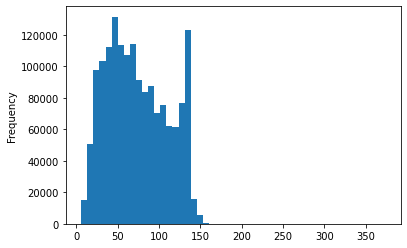

In [125]:
text_len.plot.hist(bins=50)

In [58]:
text_len.value_counts(dropna=False).sort_index()

6         6
7        77
8      1182
9      1870
10     1863
       ... 
328       1
348       1
359       2
369       1
374       1
Name: text, Length: 257, dtype: int64

In [65]:
data.loc[text_len==374, 'text'].values

array(['@catfish_ohm à¹\x80à¸\x84à¹\x89à¸²à¹\x83à¸«à¹\x89à¸?à¸²à¸£à¹\x8cà¸\x95à¸¹à¸\x99à¸?à¸¸à¹\x82à¸£à¸°(à¸ªà¸±à¸ªà¹\x86+à¸¢à¸¹à¸£à¸´à¹?à¸?à¹\x84à¸\x94à¹\x89à¹?à¸\x97à¸\x99à¸\x99à¸°à¸\x9eà¸\xadà¸\x94à¸µà¸¡à¸´à¹\x82à¸?à¸°à¸«à¸§à¸\x87(à¸\x82à¸\x99à¸²à¸\x94à¹\x80à¸\x9fà¸´à¸\x99à¹?à¸?à¸¢à¸±à¸\x87à¹\x80à¸\x84à¸¢à¹\x83à¸«à¹\x89à¹\x84à¸¡à¹\x88à¹\x83à¸\x8aà¹\x88à¹\x80à¸«à¸£à¸\xad.à¹?à¸\x95à¹\x88à¸\x8aà¹\x88à¸²à¸\x87à¹\x80à¸«à¸\xadà¸°à¸£à¸²à¸¢à¸\x99à¸±à¹\x89à¸\x99à¹\x80à¸\x82à¸²à¹\x82à¸¡à¹\x80à¸\xadà¸°à¸?à¸§à¹\x88à¸²à¸\x9bà¸¥à¸²à¹?à¸¡à¸§à¹\x80à¸¢à¸\xadà¸° = '],
      dtype=object)

## date

In [69]:
data['date']

0          Mon Apr 06 22:19:45 PDT 2009
1          Mon Apr 06 22:19:49 PDT 2009
2          Mon Apr 06 22:19:53 PDT 2009
3          Mon Apr 06 22:19:57 PDT 2009
4          Mon Apr 06 22:19:57 PDT 2009
                       ...             
1599995    Tue Jun 16 08:40:49 PDT 2009
1599996    Tue Jun 16 08:40:49 PDT 2009
1599997    Tue Jun 16 08:40:49 PDT 2009
1599998    Tue Jun 16 08:40:49 PDT 2009
1599999    Tue Jun 16 08:40:50 PDT 2009
Name: date, Length: 1600000, dtype: object

In [85]:
data['date'].apply(lambda s: datetime.strptime(s.replace('PDT ', ''), '%a %b %d %H:%M:%S %Y'))

0         2009-04-06 22:19:45
1         2009-04-06 22:19:45
2         2009-04-06 22:19:45
3         2009-04-06 22:19:45
4         2009-04-06 22:19:45
                  ...        
1599995   2009-04-06 22:19:45
1599996   2009-04-06 22:19:45
1599997   2009-04-06 22:19:45
1599998   2009-04-06 22:19:45
1599999   2009-04-06 22:19:45
Name: date, Length: 1600000, dtype: datetime64[ns]

**features**:
* standard datetime features

## user

In [94]:
users = data.groupby('user').agg(
    tweets=('user', 'size'),
    ratio=('target', 'mean')
)

<AxesSubplot:ylabel='Frequency'>

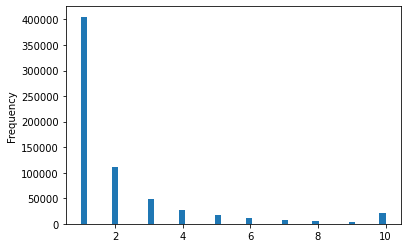

In [96]:
users['tweets'].clip(upper=10).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

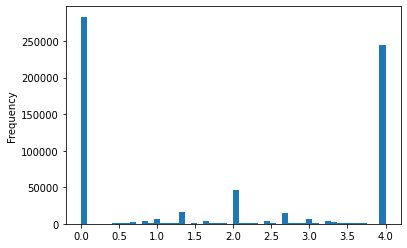

In [97]:
users['ratio'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

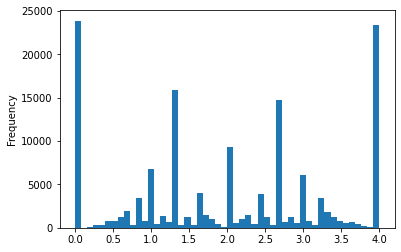

In [100]:
users[users['tweets']>2]['ratio'].plot.hist(bins=50)

**features**:
* number of tweets
* avg user_tweet_sentiment
* **!run cv by user**

## users in text

In [72]:
users_referenced = data['text'].apply(lambda s: re.findall(r'@[^ ]+', s))
users_referenced_count = users_referenced.apply(len)

In [77]:
pd.DataFrame(zip(users_referenced_count, data['target']), columns=['count', 'target']).groupby('count').agg(
    docs=('count', 'size'),
    target=('target', 'mean')
)

,docs,target
count,,
0,861177,1.682562
1,704558,2.356405
2,27201,2.582552
3,4000,2.714000
4,1470,2.982313
5,652,3.067485
6,388,3.319588
7,230,3.547826
8,170,3.647059


In [48]:
users_mentioned = sorted(set([user[1:] for users in users_in_text for user in users]))

In [47]:
len(users_mentioned)

365893

In [56]:
len(set(users_mentioned).intersection(set(data['user'])))

132384

**features**:
* number of user references in text
* avg user_tweet sentiment for user in text

## link in text

In [119]:
links_in_text = data['text'].apply(lambda s: re.findall(r'http[s]*://[^ ]+', s))

In [121]:
links_in_text.apply(len).value_counts().sort_index()

0    1529889
1      68832
2       1159
3         96
4         17
5          7
Name: text, dtype: int64

**features**
* replace link with special token
* binary flag `has_link`

## hashtags in text

In [126]:
data['text'].head(100)

0     @switchfoot http://twitpic.com/2y1zl - Awww, t...
1     is upset that he can't update his Facebook by ...
2     @Kenichan I dived many times for the ball. Man...
3       my whole body feels itchy and like its on fire 
4     @nationwideclass no, it's not behaving at all....
5                         @Kwesidei not the whole crew 
6                                           Need a hug 
7     @LOLTrish hey  long time no see! Yes.. Rains a...
8                  @Tatiana_K nope they didn't have it 
9                             @twittera que me muera ? 
10          spring break in plain city... it's snowing 
11                           I just re-pierced my ears 
12    @caregiving I couldn't bear to watch it.  And ...
13    @octolinz16 It it counts, idk why I did either...
14    @smarrison i would've been the first, but i di...
15    @iamjazzyfizzle I wish I got to watch it with ...
16    Hollis' death scene will hurt me severely to w...
17                                 about to file

In [127]:
hashtags = data['text'].apply(lambda s: re.findall(r'#[^ ]+', s))

<AxesSubplot:ylabel='Frequency'>

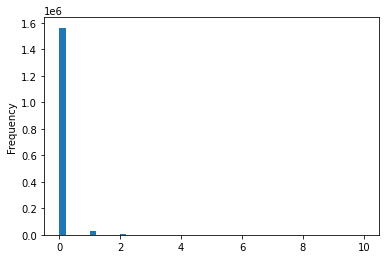

In [130]:
hashtags.apply(len).clip(upper=10).plot.hist(bins=50)

In [131]:
hashtags.apply(len).value_counts().sort_index()

0     1563742
1       31484
2        3390
3         790
4         239
5          77
6          63
7          59
8          49
9          29
10         30
11         10
12          7
14         11
15         19
24          1
Name: text, dtype: int64

In [142]:
hashtags_u = [t.lower() for ts in hashtags for t in ts]

In [143]:
from collections import Counter

sorted([(k, v) for k, v in Counter(hashtags_u).items()], key = lambda x: x[1], reverse=True)

[('#followfriday', 2299),
 ('#fb', 1778),
 ('#squarespace', 872),
 ('#ff', 826),
 ('#seb-day', 498),
 ('#iranelection', 489),
 ('#1', 405),
 ('#musicmonday', 398),
 ('#fail', 344),
 ('#asot400', 328),
 ('#iphone', 299),
 ('#iremember', 295),
 ('#bsb', 291),
 ('#myweakness', 264),
 ('#marsiscoming', 256),
 ('#f1', 244),
 ('#bgt', 237),
 ('#e3', 234),
 ('#mcflyforgermany', 230),
 ('#2', 229),
 ('#andyhurleyday', 187),
 ('#inaperfectworld', 173),
 ('#haveyouever', 168),
 ('#delongeday', 164),
 ('#mileymonday', 160),
 ('#spymaster', 156),
 ('#tcot', 155),
 ('#trackle', 155),
 ('#followfriday!', 141),
 ('#goodsex', 120),
 ('#chuckmemondays', 110),
 ('#hhrs', 105),
 ('#dontyouhate', 105),
 ('#twitter', 104),
 ('#xboxe3', 104),
 ('#mmwanted', 103),
 ('#bradiewebb', 102),
 ('#clothdiapers', 102),
 ('#flylady', 96),
 ('#follow', 93),
 ('#asylm', 93),
 ("#tag'", 92),
 ('#chesterday', 92),
 ('#eu09', 90),
 ('#bts', 88),
 ('#tweetdeck', 87),
 ('#shortstack', 86),
 ('#3', 85),
 ('#andyclemmensen', 

## emain in text

In [85]:
emails = data['text'].apply(lambda s: re.findall(r'[a-zA-z0-9.-_]+@[a-zA-z0-9.-_]+', s))

In [86]:
emails.apply(len).value_counts()

0    1597458
1       2480
2         52
3          9
4          1
Name: text, dtype: int64

In [87]:
data[emails.apply(len)>0]['text'].values[1]

'who stole elledell@gmail.com?  '

# testing preprocessors

In [6]:
from src.preproc import UserReferenceProcessor

In [7]:
UserReferenceProcessor().fit_transform(data['text'])

TypeError: _extract() missing 1 required positional argument: 'pattern'

In [226]:
data

(1, 1, 1, 1, 1, 1)

## lettes dict

In [8]:
from collections import Counter

def count_chars(s, chars):
    counter = Counter(s)
    return {c : counter.get(c,0) for c in chars}

letters_dict = Counter([c for s in data['desc'] for c in s])

In [9]:
sorted(letters_dict.items(), key=lambda i: i[1], reverse=True)

[(' ', 11269150),
 ('a', 6918402),
 ('e', 5827493),
 ('o', 5432923),
 ('i', 4519406),
 ('z', 4060100),
 ('n', 3448487),
 ('s', 3133460),
 ('r', 2971734),
 ('k', 2774425),
 ('y', 2761594),
 ('w', 2572928),
 ('t', 2412194),
 ('p', 2306489),
 ('m', 2204999),
 ('c', 2117288),
 ('d', 2068713),
 ('l', 1826311),
 ('b', 1633695),
 ('u', 1422661),
 ('j', 1374134),
 ('.', 1076430),
 ('ł', 1008407),
 (',', 807210),
 ('g', 713406),
 ('ó', 465146),
 ('ę', 448375),
 ('ż', 416814),
 ('P', 367068),
 ('ą', 360837),
 ('h', 338778),
 ('S', 288760),
 ('!', 278291),
 ('ś', 273548),
 ('f', 228596),
 ('\r', 219740),
 ('ć', 212443),
 ('B', 174693),
 ('A', 170350),
 ('W', 166578),
 ('O', 155386),
 ('D', 154107),
 ('T', 147638),
 ('Z', 133755),
 ('J', 133418),
 ('E', 132228),
 ('N', 122486),
 ('K', 104327),
 ('\n', 104190),
 ('M', 102931),
 (')', 99456),
 ('C', 95883),
 ('I', 91000),
 ('-', 84443),
 ('0', 83453),
 ('R', 82176),
 (':', 75159),
 ('L', 61472),
 ('ń', 60901),
 ('1', 58551),
 ('G', 48068),
 ('Y', 40

In [ ]:
# todo: \r, \n, \xa0 to space

## filter alpha num and punctuation

In [49]:
a = '257 najlepszy moment ψψ'
b = 'اغلاق الكلبة العربي يمارس الجنس مع ما يصل'
c = "stara ''sowiecka szkola'' zaczynam sie zastanawiac czy mozna by ich legalnie zdelegalizowac ?"
d = 'Dobrze. Szkoda, że InPost nie precyzuje co oznacza, że dostarcza przesyłkę "OD RANA"'
e = '  asd  asd  '
f = 'łączńie ćma grzegżźółka'
g = 'Bardzo przyjazny klientom sklep. \\Realizuje, wszystkie zamówienai: takie - takie '
h = 'Szanowni Państwo, ODRADZAM !!!\r\r\r\n\r\r\r\n'
i = 'Szanowni Państwo,\r\r\r\n\r\r\r\n ODRADZAM !!!'
j = 'what???????!!!!!!!!!'

tt = [a,b,c,d,e,f,g,h,i,j]

In [25]:


for s in tt:
    c = re.sub(special, ' ', s)
    c = re.sub(alpha, '', c)
    c = re.sub('\s+', ' ', c)
    c = c.strip()
    print(f"len: {len(c)}|{c}|")

len: 20|257 najlepszy moment|
len: 0||
len: 93|stara ''sowiecka szkola'' zaczynam sie zastanawiac czy mozna by ich legalnie zdelegalizowac ?|
len: 84|Dobrze. Szkoda, że InPost nie precyzuje co oznacza, że dostarcza przesyłkę "OD RANA"|
len: 7|asd asd|
len: 23|łączńie ćma grzegżźółka|
len: 78|Bardzo przyjazny klientom sklep. Realizuje, wszystkie zamówienai takie - takie|
len: 30|Szanowni Państwo, ODRADZAM !!!|
len: 30|Szanowni Państwo, ODRADZAM !!!|
len: 20|what???????!!!!!!!!!|


## frequency of tokens

In [38]:
from collections import defaultdict

In [39]:
frequency = defaultdict(int)
for text in data['tokens']:
    for token in text:
        frequency[token] += 1

In [40]:
frequency

defaultdict(int,
            {'polecam': 315905,
             'nie': 172775,
             'pierwszy': 10598,
             'i': 398206,
             'ostatni': 3423,
             'raz': 28057,
             'bardzo': 252797,
             'dobra': 28714,
             'komunikacja': 3123,
             'sms': 2372,
             'telefoniczna': 1045,
             'zamówiony': 4361,
             'towar': 83812,
             'wysłany': 1749,
             'w': 315221,
             'terminie': 4839,
             'dobrze': 32991,
             'zabezpieczony': 3448,
             'ten': 26560,
             'sklep': 128962,
             'zakupy': 56549,
             'tym': 46192,
             'sklepie': 41588,
             'są': 20369,
             'dostępne': 1703,
             'części': 5887,
             'nawet': 13004,
             'do': 93989,
             'starszych': 154,
             'modeli': 285,
             'np': 2586,
             'lodówek': 14,
             'jestem': 78910,
           

In [41]:
sorted(frequency.items(), key = lambda kv: kv[1], reverse=True)

[('i', 398206),
 ('polecam', 315905),
 ('w', 315221),
 ('bardzo', 252797),
 ('z', 240630),
 ('szybka', 192250),
 ('na', 173409),
 ('nie', 172775),
 ('to', 139799),
 ('szybko', 132690),
 ('sklep', 128962),
 ('wszystko', 114579),
 ('jak', 111862),
 ('obsługa', 95065),
 ('do', 93989),
 ('się', 93382),
 ('towar', 83812),
 ('sprawnie', 80236),
 ('jestem', 78910),
 ('ceny', 77569),
 ('zamówienia', 76376),
 ('realizacja', 74926),
 ('super', 73526),
 ('jest', 68724),
 ('dostawa', 65171),
 ('wysyłka', 64225),
 ('a', 62856),
 ('bez', 62555),
 ('że', 59991),
 ('zakupy', 56549),
 ('o', 53872),
 ('zadowolona', 51508),
 ('za', 48569),
 ('po', 47569),
 ('co', 47237),
 ('tym', 46192),
 ('transakcja', 45102),
 ('kontakt', 45036),
 ('dobry', 44991),
 ('przesyłka', 43729),
 ('zgodny', 43048),
 ('opisem', 42400),
 ('sklepie', 41588),
 ('ale', 41165),
 ('tak', 36785),
 ('ze', 36246),
 ('zawsze', 35920),
 ('już', 34291),
 ('dobrze', 32991),
 ('od', 31796),
 ('ok', 31697),
 ('zamówienie', 30467),
 ('błyskawi

In [43]:
sorted(frequency.items(), key = lambda kv: kv[1], reverse=False)

[('półtłusty', 1),
 ('slladnikiem', 1),
 ('wyrównano', 1),
 ('przydługawa', 1),
 ('maaasą', 1),
 ('ciogwiazdkowym', 1),
 ('długotrwała', 1),
 ('smsai', 1),
 ('szyfrowany', 1),
 ('najważniejszę', 1),
 ('regital', 1),
 ('przeterminowaniem', 1),
 ('wyprzedawany', 1),
 ('odkręciłem', 1),
 ('sklepiem', 1),
 ('abroad', 1),
 ('oczymalam', 1),
 ('pczka', 1),
 ('zakoszony', 1),
 ('zamaiwane', 1),
 ('potłukł', 1),
 ('farmaceutyku', 1),
 ('wzmiankowaną', 1),
 ('przrebiegało', 1),
 ('plasterki', 1),
 ('przyśpieszające', 1),
 ('gojenie', 1),
 ('postrzałowe', 1),
 ('zagoiły', 1),
 ('realizicji', 1),
 ('dostareczania', 1),
 ('skleu', 1),
 ('napotkały', 1),
 ('skontktowała', 1),
 ('boe', 1),
 ('wanosci', 1),
 ('agencją', 1),
 ('odnosniebproduktow', 1),
 ('poszukiwaneho', 1),
 ('zadawlający', 1),
 ('kojazyc', 1),
 ('kosmetykiempolecam', 1),
 ('kolorystyczną', 1),
 ('zafowoleni', 1),
 ('interpersonalne', 1),
 ('sptekach', 1),
 ('pełeny', 1),
 ('luteina', 1),
 ('akupuy', 1),
 ('ppierwszy', 1),
 ('niedost

# load preprocessed pickle

In [123]:
meta = PickleLoader(data_type='meta').load()

INFO:2021-10-30 14:31:19:io:loading from pickle: ./data/20211026_225637/df_prepro_metadata.pkl
INFO:2021-10-30 14:31:19:io:loaded 1 rows


In [124]:
meta

,ts,params,working_dir,git_branch,git_commit,git_sha,shape,columns
0,20211026_225637,"{'text_cleaning__keep_digits': True, 'text_cle...",/home/mic/Pulpit/pyProj/gensim,master,separate load and preprocessing in prep_data.py\n,e213422d2c827ff60027a8b5dbf8917a78822f49,"(917525, 8)","[desc, len, negative, desc_clean, len_clean, l..."


In [3]:
data = PickleLoader().load()

INFO:2021-10-28 20:40:00:io:loading from pickle: ./data/20211026_225637/df_prepro.pkl
INFO:2021-10-28 20:40:05:io:loaded 917525 rows


In [30]:
data.head()

,desc,len,negative,desc_clean,len_clean,len_clean_ratio,tokens,tokens_len
0,Polecam nie pierwszy i nie ostatni raz!,39,0.0,polecam nie pierwszy i nie ostatni raz,38,0.974359,"[polecam, nie, pierwszy, i, nie, ostatni, raz]",7
1,Bardzo dobra komunikacja sms i telefoniczna. Z...,121,0.0,bardzo dobra komunikacja sms i telefoniczna za...,117,0.966942,"[bardzo, dobra, komunikacja, sms, i, telefonic...",16
2,Polecam zakupy w tym sklepie. Są dostępne częś...,87,0.0,polecam zakupy w tym sklepie są dostępne częśc...,84,0.965517,"[polecam, zakupy, w, tym, sklepie, są, dostępn...",14
3,Jestem w pełni zadowolona z przebiegu transakcji,48,0.0,jestem w pełni zadowolona z przebiegu transakcji,48,1.000000,"[jestem, w, pełni, zadowolona, z, przebiegu, t...",7
4,Transakcja przebiegła błyskawicznie. Pełen pro...,86,0.0,transakcja przebiegła błyskawicznie pełen prof...,84,0.976744,"[transakcja, przebiegła, błyskawicznie, pełen,...",9


# modeling

## imports

In [7]:
import gensim
from gensim import corpora, models

## dictionary

In [8]:
# Create dictionary
dictionary = corpora.Dictionary(data['tokens'])

In [9]:
print(f"unique tokens count: {len(dictionary)}")

unique tokens count: 260521


In [94]:
dictionary.token2id['hej']

3051

In [105]:
dictionary[0]

'i'

In [110]:
dictionary.doc2bow(['takie', 'tam', 'tu', 'tam'])

[(129, 2), (1165, 1), (2545, 1)]

In [112]:
dictionary.doc2bow('takie ładne cośik'.split())

[(2545, 1), (8059, 1)]

In [122]:
# number token occurances
dictionary.cfs[dictionary.token2id['i']]

398206

In [123]:
# number of documents with this token
dictionary.dfs[dictionary.token2id['i']]

322975

In [124]:
import copy

In [205]:
d2 = copy.copy(dictionary)

In [197]:
d2.filter_extremes(no_below=50, no_above=0.3, keep_n=10000, keep_tokens=None)

INFO:2021-10-28 01:01:13:gensim.corpora.dictionary:discarding 250521 tokens: [('i', 322975), ('polecam', 311848), ('lodówek', 14), ('szybę', 36), ('elastyczna', 51), ('wyrozumiała', 41), ('magiczne', 7), ('pomylono', 51), ('różowo', 8), ('wybrakowany', 25)]...
INFO:2021-10-28 01:01:13:gensim.corpora.dictionary:keeping 10000 tokens which were in no less than 50 and no more than 275257 (=30.0%) documents
INFO:2021-10-28 01:01:13:gensim.corpora.dictionary:resulting dictionary: Dictionary(10000 unique tokens: ['nie', 'ostatni', 'pierwszy', 'raz', 'bardzo']...)


In [198]:
len(d2)

10000

In [206]:
d2.filter_extremes(no_below=None, no_above=None, keep_n=None, keep_tokens=None)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [207]:
dd = {'a': None, 'b': None}
dd

{'a': None, 'b': None}

In [210]:
if dict():
    print('hi')

In [211]:
dict()

{}

## corpus to pd

In [152]:
import scipy as sp

In [199]:
l = [['nie', 'raz', 'dobrze', 'ten'], ['dobra', 'do']]
# l = [['nie', 'raz', 'dobrze', 'ten']]

corpus = [d2.doc2bow(t) for t in l]
corpus

[[(0, 1), (3, 1), (6, 1), (11, 1)], [(5, 1), (19, 1)]]

In [200]:
i, j, data = zip(*((i, t[0], t[1]) for i, row in enumerate(corpus) for t in row))

In [201]:
mm = sp.sparse.coo_matrix((data, (i, j)), shape=(len(corpus), len(d2)))

In [202]:
pd.DataFrame.sparse.from_spmatrix(mm)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## corpus

In [178]:
corpus = [dictionary.doc2bow(tokens) for tokens in data['tokens']]

In [14]:
len(corpus)

917525

In [111]:
corpus[0]

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1)]

In [129]:
d2.items()

ItemsView(<gensim.corpora.dictionary.Dictionary object at 0x7f59d5407280>)

In [219]:
for x in tfidf[corpus][:20]:
    print(x)

[(0, 0.13595079358327705), (3, 0.5820688743040994), (6, 0.1847102734992555), (11, 0.7801251964616102)]
[(5, 0.5519210881824143), (19, 0.8338963439298314)]


# tfidf

In [179]:
tfidf = models.TfidfModel(corpus, smartirs='ntc')

INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:collecting document frequencies
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #0
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #10000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #20000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #30000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #40000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #50000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #60000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #70000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #80000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PROGRESS: processing document #90000
INFO:2021-10-28 00:58:50:gensim.models.tfidfmodel:PR

In [183]:
tfidf2 = models.TfidfModel(dictionary=dictionary, smartirs='ntc')

In [203]:
tfidf3 = models.TfidfModel(dictionary=d2, smartirs='ntc')

In [87]:
aa = [(0, 0.459457157251916), (2, 0.8881999328135463)]

In [180]:
tfidf[dictionary.doc2bow('takie ładne cośik'.split())]

[(2545, 0.5834586599705951), (8059, 0.8121428397180619)]

In [181]:
tfidf2[dictionary.doc2bow('takie ładne cośik'.split())]

[(2545, 0.5834586599705951), (8059, 0.8121428397180619)]

In [204]:
tfidf3[d2.doc2bow('takie ładne cośik'.split())]

[(1970, 0.5834586599705951), (4630, 0.8121428397180619)]

In [86]:
tfidf[(0, 1), (1, 1)]

[(0, 0.459457157251916), (1, 0.8881999328135463)]

In [82]:
tfidf[dictionary.doc2bow('takie ładne coś'.split())]

[(619, 0.505178657383013),
 (2545, 0.5035334516797687),
 (8059, 0.7008912805593708)]

In [81]:
tfidf[dictionary.doc2bow('takie ładne coś coś'.split())]

[(619, 0.7603732142847507),
 (2545, 0.3789484606664178),
 (8059, 0.5274757237606572)]

In [17]:
# count vectorizer reprezentation
corpus[0]

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1)]

In [75]:
corpus[0]

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1)]

In [74]:
tfidf[corpus[0]]

[(0, 0.11502465340007656),
 (1, 0.4447199823065697),
 (2, 0.6162766796694312),
 (3, 0.49247428983038594),
 (4, 0.11888695562762791),
 (5, 0.3905527956380666)]

In [310]:
# tfidf vectorizer reprezentation
tfidf[corpus][0]

[(0, 0.11502465340007656),
 (1, 0.4447199823065697),
 (2, 0.6162766796694312),
 (3, 0.49247428983038594),
 (4, 0.11888695562762791),
 (5, 0.3905527956380666)]

In [315]:
[(dictionary[tok_id], tok_freq) for tok_id, tok_freq in tfidf[corpus][0]]

[('i', 0.11502465340007656),
 ('nie', 0.4447199823065697),
 ('ostatni', 0.6162766796694312),
 ('pierwszy', 0.49247428983038594),
 ('polecam', 0.11888695562762791),
 ('raz', 0.3905527956380666)]

In [316]:
[(dictionary[tok_id], tok_freq) for tok_id, tok_freq in tfidf[corpus][1]]

[('i', 0.060944159953105696),
 ('polecam', 0.06299054529559758),
 ('bardzo', 0.08280210917801677),
 ('dobra', 0.20322288487180415),
 ('dobrze', 0.19508840777884015),
 ('komunikacja', 0.3317832424818046),
 ('sklep', 0.11649578839171103),
 ('sms', 0.3497153161337092),
 ('telefoniczna', 0.39583410968622923),
 ('ten', 0.20909075076732328),
 ('terminie', 0.3069124397146287),
 ('towar', 0.1416645550082417),
 ('w', 0.07953541854259781),
 ('wysłany', 0.3676203764967229),
 ('zabezpieczony', 0.3259806243987228),
 ('zamówiony', 0.31264824437629013)]

# tfidf transformer

In [4]:
from src.nlp.tfidf import TfIdfTransformer

In [18]:
tfidf_model = TfIdfTransformer()

tfidf_model.fit(data['tokens'])

TypeError: __init__() got an unexpected keyword argument 'max_df'

In [6]:
tfidf_df = tfidf_model.transform(data['tokens'])

INFO:2021-10-28 20:49:14:tfidf:creating corpus, mem used: 22.7
INFO:2021-10-28 20:49:23:tfidf:vectorizing corpus with tfidf model, mem used: 27.1
INFO:2021-10-28 20:50:08:tfidf:creating sparse corpus representation, mem used: 33.6
INFO:2021-10-28 20:50:25:tfidf:creating sparse df, mem used: 39.0


In [8]:
tfidf_df.shape

(917525, 5000)

# tfidf sklearn model

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from src.utils import mem_used

In [19]:
tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=0.5, min_df=5, max_features=5000))])

In [20]:
print(f"tfidf vectorizer start, mem used: {mem_used()}")
tfidf_mtrx = tfidf_pipe.fit_transform(data['desc_clean'])
print(f"tfidf vectorizer end, mem used: {mem_used()}")

tfidf vectorizer start, mem used: 28.0
tfidf vectorizer end, mem used: 28.5


In [21]:
print(f"sparse df start, mem used: {mem_used()}")
tfidf_df_sparse = pd.DataFrame.sparse.from_spmatrix(tfidf_mtrx, columns=tfidf_pipe.get_feature_names_out())
print(f"sparse df end, mem used: {mem_used()}")

sparse df start, mem used: 29.3
sparse df end, mem used: 27.8


In [22]:
tfidf_df_sparse.shape

(917525, 5000)

In [23]:
tfidf_pipe.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(max_df=0.5, max_features=5000, min_df=5))],
 'verbose': False,
 'tfidf': TfidfVectorizer(max_df=0.5, max_features=5000, min_df=5),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 5000,
 'tfidf__min_df': 5,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None}

In [11]:
tfidf_sk_model.get_feature_names_out()

array(['00', '000', '0000', ..., 'żłówia', 'żźe', 'żże'], dtype=object)

# catboost

In [26]:
from catboost import CatBoostClassifier

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
data_train, data_test, y_train, y_test = train_test_split(
    data[['desc_clean']], data['negative'], test_size=0.33, random_state=12345)

## catboost on clean text

In [46]:
cb_params = {
    'eval_metric': 'AUC',
    'text_features': ['desc_clean'],
    'metric_period': 10,
    'verbose': 10,
}

In [48]:
cb1 = CatBoostClassifier(**cb_params)
cb1.fit(X=data_train, y=y_train, eval_set=(data_test, y_test))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.15478
0:	test: 0.9811921	best: 0.9811921 (0)	total: 249ms	remaining: 4m 8s
10:	test: 0.9981425	best: 0.9981425 (10)	total: 4.12s	remaining: 6m 10s
20:	test: 0.9984857	best: 0.9984857 (20)	total: 7.21s	remaining: 5m 36s
30:	test: 0.9986127	best: 0.9986127 (30)	total: 10s	remaining: 5m 13s
40:	test: 0.9986980	best: 0.9986980 (40)	total: 13s	remaining: 5m 4s
50:	test: 0.9987554	best: 0.9987554 (50)	total: 16.1s	remaining: 4m 59s
60:	test: 0.9987867	best: 0.9987867 (60)	total: 18.8s	remaining: 4m 49s
70:	test: 0.9988311	best: 0.9988311 (70)	total: 21.8s	remaining: 4m 45s
80:	test: 0.9988579	best: 0.9988579 (80)	total: 24.7s	remaining: 4m 39s
90:	test: 0.9988786	best: 0.9988786 (90)	total: 27.5s	remaining: 4m 34s
100:	test: 0.9988976	best: 0.9988976 (100)	total: 30.4s	remaining: 4m 30s
110:	test: 0.9989246	best: 0.9989246 (110)	total: 33.8s	remaining: 4m 30s
120:	test: 0.9989497	best: 0.9989497 (120)	total: 37.3s	remaining: 4m 30s
130:	test: 0.9989613	best: 0.9989613 

<AxesSubplot:xlabel='pred_q10'>

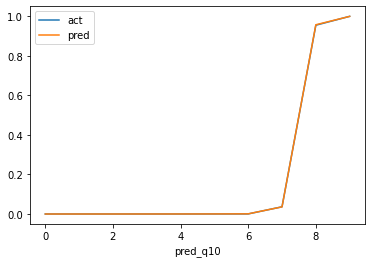

In [66]:
preds = cb1.predict_proba(data_test)
preds = [x[1] for x in preds]

X_test = pd.DataFrame(
    zip(data_test['desc_clean'], y_test, preds), 
    columns=['desc_clean', 'negative', 'pred'],
    index=data_test.index
)
X_test['pred_q10'] = pd.qcut(X_test['pred'], q=10, labels=False)

X_test.groupby('pred_q10').agg(
    act=('negative', 'mean'),
    pred=('pred', 'mean')
).plot()

In [70]:
len(data)

917525

In [73]:
len(pd.unique(data['desc']))

815161

In [69]:
len(pd.unique(data['desc_clean']))

760885

In [74]:
data['desc_clean'].value_counts()[:10]

transakcja przebiegła pomyślnie polecam       2537
wszystko w jak najlepszym porządku            2125
transakcja przebiegła pomyślnie               1913
wszystko w jak najlepszym porządku polecam    1122
wszystko w najlepszym porządku                 796
bardzo szybka realizacja zamówienia            686
wszystko w najlepszym porządku polecam         645
szybka realizacja zamówienia polecam           576
szybko sprawnie profesjonalnie                 543
wszystko szybko i sprawnie polecam             502
Name: desc_clean, dtype: int64

## catboost on deduplicated data

In [76]:
datau = data[['desc_clean', 'negative']].drop_duplicates()

In [77]:
data_trainu, data_testu, y_trainu, y_testu = train_test_split(
    datau[['desc_clean']], datau['negative'], test_size=0.33, random_state=12345)

In [78]:
cb2 = CatBoostClassifier(**cb_params)
cb2.fit(X=data_trainu, y=y_trainu, eval_set=(data_testu, y_testu))

Learning rate set to 0.147787
0:	test: 0.9783498	best: 0.9783498 (0)	total: 212ms	remaining: 3m 31s
10:	test: 0.9977877	best: 0.9977877 (10)	total: 2.88s	remaining: 4m 19s
20:	test: 0.9982901	best: 0.9982901 (20)	total: 5.84s	remaining: 4m 32s
30:	test: 0.9984367	best: 0.9984367 (30)	total: 9.17s	remaining: 4m 46s
40:	test: 0.9985372	best: 0.9985372 (40)	total: 12s	remaining: 4m 39s
50:	test: 0.9985920	best: 0.9985920 (50)	total: 14.4s	remaining: 4m 28s
60:	test: 0.9986588	best: 0.9986588 (60)	total: 17.2s	remaining: 4m 24s
70:	test: 0.9987122	best: 0.9987122 (70)	total: 19.9s	remaining: 4m 20s
80:	test: 0.9987579	best: 0.9987579 (80)	total: 22.6s	remaining: 4m 15s
90:	test: 0.9987848	best: 0.9987848 (90)	total: 25.2s	remaining: 4m 11s
100:	test: 0.9988103	best: 0.9988103 (100)	total: 28s	remaining: 4m 9s
110:	test: 0.9988231	best: 0.9988231 (110)	total: 30.7s	remaining: 4m 6s
120:	test: 0.9988459	best: 0.9988459 (120)	total: 33.9s	remaining: 4m 5s
130:	test: 0.9988709	best: 0.9988709 

<AxesSubplot:xlabel='pred_q10'>

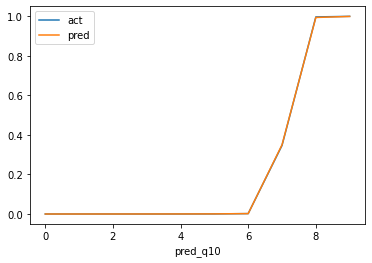

In [80]:
preds = cb2.predict_proba(data_testu)
preds = [x[1] for x in preds]

X_test = pd.DataFrame(
    zip(data_testu['desc_clean'], y_testu, preds), 
    columns=['desc_clean', 'negative', 'pred'],
    index=data_testu.index
)
X_test['pred_q10'] = pd.qcut(X_test['pred'], q=10, labels=False)

X_test.groupby('pred_q10').agg(
    act=('negative', 'mean'),
    pred=('pred', 'mean')
).plot()

## cat boost on dedup with holdout

In [ ]:
datau = data[['desc_clean', 'negative']].drop_duplicates()

In [83]:
data_train, data_valid, y_train, y_valid = train_test_split(
    datau[['desc_clean']], datau['negative'], test_size=0.20, random_state=12345)

In [84]:
data_train, data_test, y_train, y_test = train_test_split(
    data_train, y_train, test_size=0.20, random_state=12345)

In [85]:
cb3 = CatBoostClassifier(**cb_params)
cb3.fit(X=data_train, y=y_train, eval_set=(data_test, y_test))

Learning rate set to 0.146124
0:	test: 0.9795594	best: 0.9795594 (0)	total: 225ms	remaining: 3m 44s
10:	test: 0.9977828	best: 0.9977828 (10)	total: 2.88s	remaining: 4m 19s
20:	test: 0.9982653	best: 0.9982653 (20)	total: 9.64s	remaining: 7m 29s
30:	test: 0.9984651	best: 0.9984651 (30)	total: 13s	remaining: 6m 44s
40:	test: 0.9985523	best: 0.9985523 (40)	total: 16.6s	remaining: 6m 27s
50:	test: 0.9986336	best: 0.9986336 (50)	total: 22.5s	remaining: 6m 58s
60:	test: 0.9986830	best: 0.9986830 (60)	total: 24.8s	remaining: 6m 22s
70:	test: 0.9987344	best: 0.9987344 (70)	total: 32.4s	remaining: 7m 3s
80:	test: 0.9987736	best: 0.9987736 (80)	total: 35.3s	remaining: 6m 40s
90:	test: 0.9987995	best: 0.9987995 (90)	total: 38.9s	remaining: 6m 28s
100:	test: 0.9988261	best: 0.9988261 (100)	total: 44.6s	remaining: 6m 37s
110:	test: 0.9988530	best: 0.9988530 (110)	total: 46.9s	remaining: 6m 15s
120:	test: 0.9988778	best: 0.9988778 (120)	total: 54.1s	remaining: 6m 32s
130:	test: 0.9988956	best: 0.9988

<AxesSubplot:xlabel='pred_q10'>

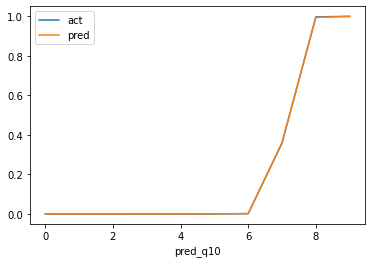

In [86]:
preds = cb3.predict_proba(data_test)
preds = [x[1] for x in preds]

X_test = pd.DataFrame(
    zip(data_testu['desc_clean'], y_test, preds), 
    columns=['desc_clean', 'negative', 'pred'],
    index=data_test.index
)
X_test['pred_q10'] = pd.qcut(X_test['pred'], q=10, labels=False)

X_test.groupby('pred_q10').agg(
    act=('negative', 'mean'),
    pred=('pred', 'mean')
).plot()

<AxesSubplot:xlabel='pred_q10'>

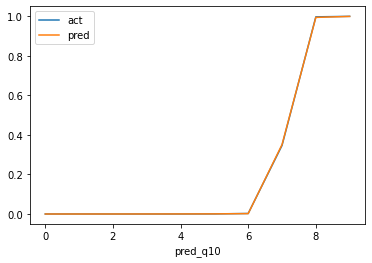

In [87]:
preds = cb3.predict_proba(data_valid)
preds = [x[1] for x in preds]

X_test = pd.DataFrame(
    zip(data_testu['desc_clean'], y_valid, preds), 
    columns=['desc_clean', 'negative', 'pred'],
    index=data_valid.index
)
X_test['pred_q10'] = pd.qcut(X_test['pred'], q=10, labels=False)
X_test['len'] = X_test['desc_clean'].apply(len)


X_test.groupby('pred_q10').agg(
    act=('negative', 'mean'),
    pred=('pred', 'mean')
).plot()

<AxesSubplot:xlabel='pred_q10'>

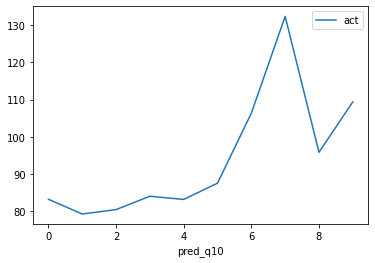

In [96]:
X_test.groupby('pred_q10').agg(
    act=('len', 'mean')
).plot()

# catboost on tfidf

,desc,len,negative,desc_clean,len_clean,len_clean_ratio,tokens,tokens_len
0,Polecam nie pierwszy i nie ostatni raz!,39,0.0,polecam nie pierwszy i nie ostatni raz,38,0.974359,"[polecam, nie, pierwszy, i, nie, ostatni, raz]",7
1,Bardzo dobra komunikacja sms i telefoniczna. Z...,121,0.0,bardzo dobra komunikacja sms i telefoniczna za...,117,0.966942,"[bardzo, dobra, komunikacja, sms, i, telefonic...",16
2,Polecam zakupy w tym sklepie. Są dostępne częś...,87,0.0,polecam zakupy w tym sklepie są dostępne częśc...,84,0.965517,"[polecam, zakupy, w, tym, sklepie, są, dostępn...",14
3,Jestem w pełni zadowolona z przebiegu transakcji,48,0.0,jestem w pełni zadowolona z przebiegu transakcji,48,1.000000,"[jestem, w, pełni, zadowolona, z, przebiegu, t...",7
4,Transakcja przebiegła błyskawicznie. Pełen pro...,86,0.0,transakcja przebiegła błyskawicznie pełen prof...,84,0.976744,"[transakcja, przebiegła, błyskawicznie, pełen,...",9
...,...,...,...,...,...,...,...,...
917520,Coraz lepiej wygląda,20,1.0,coraz lepiej wygląda,20,1.000000,"[coraz, lepiej, wygląda]",3
917521,JA SRAM NA TEN PIERSCIONEK I NA CIEBIE CHWILE ...,89,1.0,ja sram na ten pierscionek i na ciebie chwile ...,89,1.000000,"[ja, sram, na, ten, pierscionek, i, na, ciebie...",17
917522,Rafatus do Marleny Ty kurwo bez honoru ...,126,1.0,rafatus do marleny ty kurwo bez honoru kto tu ...,91,0.722222,"[rafatus, do, marleny, ty, kurwo, bez, honoru,...",16
917523,matka Marleny prosi o pomoc,29,1.0,matka marleny prosi o pomoc,27,0.931034,"[matka, marleny, prosi, o, pomoc]",5


# preproc and tokenize user sentence

In [33]:

from src.preproc import RawDataCleaner, TextCleaner, SimpleTokenizer

In [34]:
tokenizer = SimpleTokenizer()

In [35]:
tokenizer.tokenize('a co tam!')

['a', 'co', 'tam!']

# w2v

In [3]:
with open('./data/data_preproc.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
model

In [4]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=data['tokens'], vector_size=25, window=5, min_count=1, workers=4)
model.save("./models/word2vec.model")

FileNotFoundError: [Errno 2] No such file or directory: './models/word2vec.model'

In [6]:
from datetime import datetime

In [7]:
dateTimeObj = datetime.now()

In [8]:
print(dateTimeObj)

2021-10-25 23:07:27.035741


In [10]:
timestampStr = dateTimeObj.strftime("%Y%m%d_%H%M%S")
print(timestampStr)

20211025_230727


# test single sentence wrapper

# test single column transformers

In [63]:
a = '257 najlepszy moment ψψ'
b = 'اغلاق الكلبة العربي يمارس الجنس مع ما يصل'
c = "stara ''sowiecka szkola'' zaczynam sie zastanawiac czy mozna by ich legalnie zdelegalizowac ?"
d = 'Dobrze. Szkoda, że InPost nie precyzuje co oznacza, że dostarcza przesyłkę "OD RANA"'
e = '  asd  asd  '
f = 'łączńie ćma grzegżźółka'
g = 'Bardzo przyjazny klientom sklep. \\Realizuje, wszystkie zamówienai: takie - takie '
h = 'Szanowni Państwo, ODRADZAM !!!\r\r\r\n\r\r\r\n'
i = 'Szanowni Państwo,\r\r\r\n\r\r\r\n ODRADZAM !!!'
j = 'what???????!!!!!!!!!'

tt = [a,b,c,d,e,f,g,h,i,j]

In [47]:
from src.preproc_columns import TextCleaner, SimpleTokenizer

In [58]:
TextCleaner().transform(tt)

['257 najlepszy moment',
 '',
 'stara sowiecka szkola zaczynam sie zastanawiac czy mozna by ich legalnie zdelegalizowac',
 'dobrze szkoda że inpost nie precyzuje co oznacza że dostarcza przesyłkę od rana',
 'asd asd',
 'łączńie ćma grzegżźółka',
 'bardzo przyjazny klientom sklep realizuje wszystkie zamówienai takie takie',
 'szanowni państwo odradzam',
 'szanowni państwo odradzam',
 'what']

In [61]:
TextCleaner().fit_transform(tt)

['257 najlepszy moment',
 '',
 'stara sowiecka szkola zaczynam sie zastanawiac czy mozna by ich legalnie zdelegalizowac',
 'dobrze szkoda że inpost nie precyzuje co oznacza że dostarcza przesyłkę od rana',
 'asd asd',
 'łączńie ćma grzegżźółka',
 'bardzo przyjazny klientom sklep realizuje wszystkie zamówienai takie takie',
 'szanowni państwo odradzam',
 'szanowni państwo odradzam',
 'what']

In [57]:
TextCleaner().transform('takie tam!??   oj 12')

'takie tam oj 12'

In [60]:
TextCleaner().fit_transform('takie tam!??   oj 12')

'takie tam oj 12'

In [67]:
prep_p = Pipeline([
    ('clean', TextCleaner()),
    ('tokenize', SimpleTokenizer())
])

In [70]:
prep_p.transform(tt)

[['257', 'najlepszy', 'moment'],
 [],
 ['stara',
  'sowiecka',
  'szkola',
  'zaczynam',
  'sie',
  'zastanawiac',
  'czy',
  'mozna',
  'by',
  'ich',
  'legalnie',
  'zdelegalizowac'],
 ['dobrze',
  'szkoda',
  'że',
  'inpost',
  'nie',
  'precyzuje',
  'co',
  'oznacza',
  'że',
  'dostarcza',
  'przesyłkę',
  'od',
  'rana'],
 ['asd', 'asd'],
 ['łączńie', 'ćma', 'grzegżźółka'],
 ['bardzo',
  'przyjazny',
  'klientom',
  'sklep',
  'realizuje',
  'wszystkie',
  'zamówienai',
  'takie',
  'takie'],
 ['szanowni', 'państwo', 'odradzam'],
 ['szanowni', 'państwo', 'odradzam'],
 ['what']]

# adhoc

In [52]:
for x in ['aaa']:
    print(x)

aaa


In [45]:
''.split()

[]

In [44]:
[1].copy()

[1]

In [ ]:
datasets = pd.DataFrame(columns=['id', 'ts', 'params', 'git_branch', 'git_commit', 'shape', 'columns'])

In [128]:
import os

os.mkdir('./data/test')

,a,b
0,1,2


In [138]:
aa = pd.DataFrame(columns=['c', 'd'])
aa.append(pd.Series((1,2)).to_frame().T)


,c,d,0,1
0,NaN,NaN,1.0,2.0


'./data/er'

In [141]:
with open('./data/20211026_020140/df_prepro_metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

In [142]:
metadata

,ts,params,working_dir,git_branch,git_commit,git_sha,shape,columns
0,20211026_020140,{'load_data__file_name': 'polish_sentiment_dat...,/home/mic/Pulpit/pyProj/gensim,master,add prep_data.py modelue for running data prep...,5dbad2a69f2ea7004d30e2c21206c03d4bdfec36,"(917525, 8)","[desc, len, negative, desc_clean, len_clean, l..."
